In [1]:
import getpass
user_id = getpass.getuser()

import sys
sys.path.append(f"/home/{user_id}/OTTEHR/")

from collections import Counter
from common import *
from googletrans import Translator
import matplotlib.pyplot as plt
from mimic_common import *

base_path = f"/home/{user_id}/OTTEHR/mimiciv_exp"
output_path = f"/home/{user_id}/OTTEHR/outputs/mimiciv"

2024-02-28 21:34:26.319253: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-28 21:34:26.363820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 21:34:26.363862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 21:34:26.365016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 21:34:26.371431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

The goal is to study the fairness diagnosis ICD codes vs prescription for different races

Step 1: Select source and target samples 

In [2]:
df = pd.read_csv(os.path.join(base_path, "mimiciv/final_admission.csv"), converters={'diagnosis_icd_code': literal_eval, 'procedure_icd_code': literal_eval, 'drug': literal_eval})
display(df)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,edouttime,hospital_expire_flag,gender,anchor_age,anchor_year,anchor_year_group,dod,diagnosis_icd_code,procedure_icd_code,drug
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,2180-05-06 23:30:00,0,F,52,2180,2014 - 2016,2180-09-09,"[5723, 78959, 5715, 07070, 496, 29680, 30981, ...",[5491],"[Acetaminophen, Sodium Chloride 0.9% Flush, F..."
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,2180-06-26 21:31:00,0,F,52,2180,2014 - 2016,2180-09-09,"[07071, 78959, 2875, 2761, 496, 5715, V08, 3051]",[5491],"[Rifaximin, Lactulose, Calcium Carbonate, Furo..."
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,2180-08-06 01:44:00,0,F,52,2180,2014 - 2016,2180-09-09,"[07054, 78959, V462, 5715, 2767, 2761, 496, V0...",[5491],"[Albumin 25% (12.5g / 50mL), Calcium Carbonate..."
3,10000117,27988844,2183-09-18 18:10:00,2183-09-21 16:30:00,NaN,OBSERVATION ADMIT,P75S70,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Other,...,2183-09-18 20:20:00,0,F,48,2174,2008 - 2010,NaN,"[S72012A, W010XXA, Y93K1, Y92480, K219, E7800,...",[0QS734Z],"[Senna, Bisacodyl, Cepacol (Sore Throat Lozeng..."
4,10000560,28979390,2189-10-15 10:30:00,2189-10-17 15:00:00,NaN,SURGICAL SAME DAY ADMISSION,P08ZLF,PHYSICIAN REFERRAL,HOME,Other,...,NaN,0,F,53,2189,2008 - 2010,NaN,"[1890, V1582, V1201]",[5551],"[Scopolamine Patch, Ketorolac, Lorazepam, Pota..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220848,19999828,25744818,2149-01-08 16:44:00,2149-01-18 17:00:00,NaN,EW EMER.,P75BG6,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,...,2149-01-08 18:12:00,0,F,46,2147,2017 - 2019,NaN,"[T8141XA, E1110, K632, D682, L02211, T83728A, ...","[0J980ZZ, 0WPF0JZ, 05HY33Z]","[Insulin, Potassium Chloride, Insulin, Insulin..."
220849,19999828,29734428,2147-07-18 16:23:00,2147-08-04 18:10:00,NaN,EW EMER.,P16C7J,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,...,2147-07-18 17:34:00,0,F,46,2147,2017 - 2019,NaN,"[T8131XA, T8183XA, K632, D6851, N390, Y838, Y9...","[0HR7X74, 0HBJXZZ, 0HBHXZZ, 02HV33Z, 3E0436Z]","[Insulin, Potassium Chloride (Powder), Acetami..."
220850,19999840,21033226,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,EW EMER.,P58A9J,EMERGENCY ROOM,DIED,Other,...,2164-09-10 14:46:00,1,M,58,2164,2008 - 2010,2164-09-17,"[3453, 51881, 5070, 5180, 42741, 43821, 43811,...","[9604, 9672, 966, 0331, 0331]","[Potassium Chloride, Bisacodyl, Phenytoin, 0.9..."
220851,19999840,26071774,2164-07-25 00:27:00,2164-07-28 12:15:00,NaN,EW EMER.,P506DE,EMERGENCY ROOM,HOME,Other,...,2164-07-25 01:20:00,0,M,58,2164,2008 - 2010,2164-09-17,"[43491, 43820, 34590, 43811, 4019, 2724, 3051]","[8891, 8841]","[Metoprolol Tartrate, Sodium Chloride 0.9% Fl..."


In [3]:
# Display all races
all_races = df['race']
Counter(all_races)

Counter({'WHITE': 144363,
         'BLACK/AFRICAN AMERICAN': 24628,
         'UNKNOWN': 8291,
         'OTHER': 8015,
         'WHITE - OTHER EUROPEAN': 4210,
         'HISPANIC OR LATINO': 3622,
         'HISPANIC/LATINO - PUERTO RICAN': 3458,
         'ASIAN': 3198,
         'ASIAN - CHINESE': 2974,
         'BLACK/CAPE VERDEAN': 2314,
         'HISPANIC/LATINO - DOMINICAN': 2004,
         'WHITE - RUSSIAN': 1857,
         'UNABLE TO OBTAIN': 1298,
         'BLACK/CARIBBEAN ISLAND': 1264,
         'PATIENT DECLINED TO ANSWER': 1259,
         'BLACK/AFRICAN': 1033,
         'PORTUGUESE': 816,
         'ASIAN - SOUTH EAST ASIAN': 789,
         'WHITE - BRAZILIAN': 634,
         'HISPANIC/LATINO - GUATEMALAN': 629,
         'ASIAN - ASIAN INDIAN': 619,
         'WHITE - EASTERN EUROPEAN': 571,
         'AMERICAN INDIAN/ALASKA NATIVE': 491,
         'HISPANIC/LATINO - SALVADORAN': 446,
         'HISPANIC/LATINO - COLUMBIAN': 283,
         'HISPANIC/LATINO - MEXICAN': 267,
         'MULTI

In [4]:
# If source_num and target_num are not the same, we cannot perform exact OT mapping
# we may get an unrealistic counterpart, and the prediction may be unreliable

source_num = 1000
target_num = 1000
selected_df = select_samples(df, 'race', 'WHITE', 'ASIAN', source_num, target_num)

In [5]:
source_features, source_labels, target_features, target_labels = gen_code_feature_label(selected_df, 'race', 'WHITE', 'ASIAN', 'diagnosis_icd_code', 'drug')

code is: 71536
code is: 49390
code is: 4241
code is: 73300
code is: 2749
code is: D61818
code is: I5032
code is: E872
code is: D689
code is: D599
code is: D46Z
code is: R823
code is: R319
code is: Z86718
code is: Z853
code is: Z87891
code is: I110
code is: J449
code is: E119
code is: E039
code is: E7800
code is: F329
code is: K7581
code is: I2720
code is: E790
code is: G893
code is: 72293
code is: 73028
code is: 30000
code is: 311
code is: 32723
code is: 33829
code is: 72210
code is: 3051
code is: V4364
code is: K8051
code is: K851
code is: K7581
code is: K5792
code is: Z23
code is: F411
code is: G4733
code is: Z903
code is: M80851A
code is: J9691
code is: J810
code is: F05
code is: I4891
code is: Z7901
code is: Z952
code is: I714
code is: I10
code is: E785
code is: D509
code is: H9190
code is: Z9181
code is: R339
code is: I081
code is: Z66
code is: 41401
code is: 2724
code is: 42822
code is: 4280
code is: 4168
code is: 4299
code is: 53561
code is: 2800
code is: 25000
code is: 56210
co

/home/wanxinli/OTTEHR/mimic_common.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  source_labels = np.array(list(source_df[label_name]))
/home/wanxinli/OTTEHR/mimic_common.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  target_labels = np.array(list(target_df[label_name]))


In [6]:
source_features.shape

(1000, 4078)

In [7]:
print(source_labels, target_labels)

[list(['OxycoDONE (Immediate Release) ', 'Milk of Magnesia', 'Pneumococcal Vac Polyvalent', 'Senna', 'Fluticasone Propionate NASAL', '0.9% Sodium Chloride', 'CefazoLIN', 'Atorvastatin', '0.9% Sodium Chloride', 'CefazoLIN', 'Enoxaparin Sodium', 'Sodium Chloride 0.9%  Flush', 'Morphine Sulfate', 'Morphine Sulfate', 'Acetaminophen', 'Docusate Sodium', 'Morphine Sulfate', 'Bisacodyl', 'Prochlorperazine', 'OxycoDONE (Immediate Release) ', 'DiphenhydrAMINE', 'Pantoprazole', 'Sarna Lotion', 'Midazolam', 'Vitamin D', 'Potassium Chl 20 mEq / 1000 mL D5 1/2 NS', 'Calcium Carbonate', 'OxycoDONE (Immediate Release) '])
 list(['Bag', 'Magnesium Sulfate', 'Acetaminophen', 'Levothyroxine Sodium', 'Dextrose 50%', 'Pantoprazole', 'Sodium Chloride 0.9%  Flush', 'Furosemide', 'Furosemide', 'Potassium Chloride Replacement (Critical Care and Oncology) ', 'Furosemide', 'Potassium Chloride Replacement (Critical Care and Oncology) ', 'Vial', 'CefTRIAXone', 'Glucagon', 'Furosemide', 'Bag', 'Magnesium Sulfate',

In [8]:
print(source_features.shape, target_features.shape)

(1000, 4078) (1000, 4078)


Step 2: Optimal transport (matching between source and target features)

In [9]:
source_measure = np.ones((source_features.shape[0],))/source_features.shape[0]
target_measure = np.ones((target_features.shape[0],))/target_features.shape[0]
M = ot.dist(target_features, source_features, metric='sqeuclidean')
G = ot.emd(source_measure, target_measure, M)
row_sums = G.sum(axis=1)

normalized_G = G / row_sums[:, np.newaxis]
transp = G / np.sum(G, axis=1)[:, None]
transp[~ np.isfinite(transp)] = 0
trans_target_features = np.dot(transp, source_features)

trans_target_labels = [source_labels[int(i)] for i in np.dot(transp, np.arange(len(source_labels)))]
print(trans_target_labels)



[['Influenza Virus Vaccine', 'D5 1/2NS', 'HYDROmorphone (Dilaudid)', 'Diazepam', 'Zolpidem Tartrate', 'Temazepam', 'Acetaminophen IV', 'Clopidogrel', 'Heparin', 'Sodium Chloride 0.9%  Flush', 'Ropinirole', 'Simvastatin', 'HYDROmorphone (Dilaudid)', 'Paroxetine'], ['Heparin Flush (10 units/ml)', 'Zolpidem Tartrate', 'Metoprolol Succinate XL', 'Aspirin', 'Calcium Carbonate', '5% Dextrose', 'Gentamicin Sulfate', 'Atorvastatin', 'Lisinopril', 'Simethicone', 'Aluminum-Magnesium Hydrox.-Simethicone', 'Aluminum-Magnesium Hydrox.-Simethicone', 'Calcium Carbonate', 'Heparin', 'Pneumococcal Vac Polyvalent', 'Emtricitabine-Tenofovir (Truvada)', 'Nevirapine', 'Isotonic Sodium Chloride', 'Gentamicin', 'Iso-Osmotic Dextrose', 'CeftriaXONE', 'Docusate Sodium', 'Metoprolol Tartrate', 'Lopinavir-Ritonavir', 'Metoprolol Succinate XL', 'Iso-Osmotic Dextrose', 'CeftriaXONE'], ['Prochlorperazine', 'Docusate Sodium', 'Prochlorperazine', 'Heparin', 'Sodium Chloride 0.9%  Flush', 'Metoprolol Succinate XL', 'S

Step 3: Check if prescription changes significantly between an example with its counterpart 

In [10]:
def calc_stats(source_drug_list, target_drug_list):
    """ 
    Calculate the difference score, and drug unfairness score mapping between drug_list1 and drug_list2, 
    to assess the dissimilarity in prescription
    :param list[str] drug_list1: a drug list for a source admission
    :param list[str] drug_list2: a drug list for a target admission

    :returns:
        - float diff_score: overall difference score between two admissions for all drugs
        - map[list[float]] drug_unfairness_score: unfairness score (value, formatted in list of 1 element) for each drug (key)\
            larger absolute value indicates more unfairness, \
            positive value indicates the drug is prescribed more for source group, \
            negative value indicates the drug is prescribed more for target group
    """
    
    overlap_count = 0
    source_counter = Counter(source_drug_list)
    target_counter = Counter(target_drug_list)
    drug_unfairness_score = {} # keys being drug name, values being score

    for target_drug, _ in target_counter.items():
        drug_unfairness_score[target_drug] = [-1] # initialize drug_unfairness_score

    for source_drug, source_count in source_counter.items():
        drug_unfairness_score[source_drug] = [1] # initialize drug_unfairness_score
        if source_drug in target_counter:
            overlap_count += min(target_counter[source_drug], source_count) 

            # update drug_score if key presents in both lists
            drug_unfairness_score[source_drug] = [(source_count - target_counter[source_drug])/max(source_count, target_counter[source_drug])] 
    diff_score = 1-overlap_count/(len(source_drug_list)+len(target_drug_list)-overlap_count)
    return diff_score, drug_unfairness_score

In [11]:
def combine_drug_score(drug_unfairness_score_1, drug_unfairness_score_2):
    """ 
    Combine two drug scores from calc_stats (first returned value)

    :returns: the combined drug score
    """
    combined_drug_unfairness_score = {}
    for key in drug_unfairness_score_1:
        if key in drug_unfairness_score_2:
            combined_drug_unfairness_score[key] = drug_unfairness_score_1[key] + drug_unfairness_score_2[key]
        else:
            combined_drug_unfairness_score[key] = drug_unfairness_score_1[key]

    # Add keys from drug_score_2 not already present in combined_drug_score
    for key in drug_unfairness_score_2:
        if key not in combined_drug_unfairness_score:
            combined_drug_unfairness_score[key] = drug_unfairness_score_2[key]
    return combined_drug_unfairness_score

In [12]:
def avg_drug_score(drug_unfairness_score):
    """
    Average the fairness score for each drug

    :returns: the averaged fairness drug score map
    """
    for drug, scores in drug_unfairness_score.items():
        drug_unfairness_score[drug] = np.mean(scores)
    return drug_unfairness_score

In [13]:
def translate_to_chinese(text):
    """ 
    Translate the text to Chinese
    """
    
    translator = Translator()
    translation = translator.translate(text, dest='zh-cn')
    return translation.text

In [18]:
diff_scores = []
final_drug_unfairness_score = {}
for target_label, trans_target_label in zip(target_labels, trans_target_labels):
    diff_score, drug_unfairness_score = calc_stats(target_label, trans_target_label)
    diff_scores.append(diff_score)
    final_drug_unfairness_score = combine_drug_score(final_drug_unfairness_score, drug_unfairness_score)
final_drug_unfairness_score = avg_drug_score(final_drug_unfairness_score)
final_drug_unfairness_score = {k: v for k, v in sorted(final_drug_unfairness_score.items(), key=lambda item: item[1], reverse=False)}
print(final_drug_unfairness_score)

# write the final_drug_unfairness_score to output file
output_file = os.path.join(output_path, 'drug_unfairness_score.txt')
with open(output_file, 'w') as f:
    for key, value in final_drug_unfairness_score.items():
        f.write(f"{key}, {translate_to_chinese(key)}, {value}\n")

{'Temazepam': -1.0, 'Ropinirole': -1.0, 'Nevirapine': -1.0, 'Lopinavir-Ritonavir': -1.0, 'Niacin SR': -1.0, 'Etomidate': -1.0, 'Diluent for REGN1979': -1.0, 'INV-REGN1979': -1.0, 'Doxepin HCl': -1.0, 'Isosorbide ': -1.0, 'Milk Of Magnesia': -1.0, 'LaMOTrigine': -1.0, 'Lunesta (Eszopiclone)': -1.0, 'Carbamazepine Chewable Tabs': -1.0, 'anastrozole': -1.0, 'Miconazole Nitrate Vag Cream 2%': -1.0, 'Anusol-HC': -1.0, 'Propafenone HCl': -1.0, 'Aldesleukin': -1.0, 'Penicillin V Potassium': -1.0, 'DULoxetine DR': -1.0, 'GuaiFENesin-Dextromethorphan': -1.0, 'Symbicort': -1.0, 'treprostinil': -1.0, 'tadalafil': -1.0, 'Lomedia 24 Fe': -1.0, 'Sterile Diluent for Flolan': -1.0, 'Treprostinil Sodium': -1.0, 'Triple Omega 3-6-9': -1.0, 'Caspofungin': -1.0, 'Triamterene': -1.0, 'NS Epidural Bag (0.9% NaCl)': -1.0, 'Syringe (Intrapleural)': -1.0, 'Kcentra*': -1.0, 'Lacosamide': -1.0, 'Lithium Carbonate CR (Eskalith)': -1.0, 'LeVETiracetam Solution': -1.0, 'Hydrochloric Acid': -1.0, 'D5 1/4NS': -1.0, '

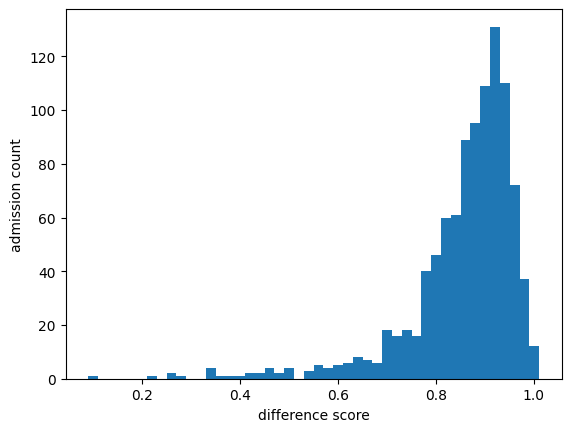

In [16]:
# Plot histogram of the difference score for all admissions

bin_width = 0.02
plt.hist(diff_scores, bins=np.arange(min(diff_scores), max(diff_scores) + bin_width, bin_width))
plt.xlabel('difference score')
plt.ylabel('admission count')
plt.show()

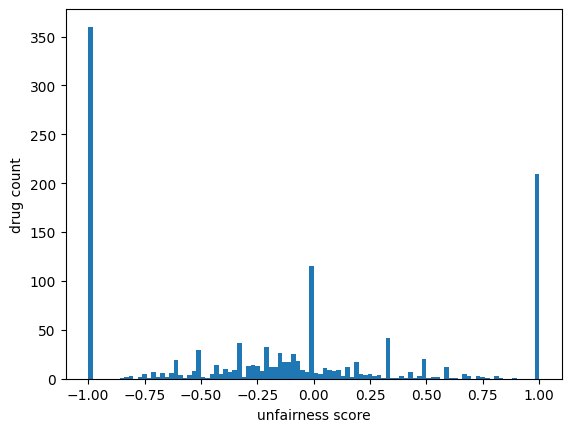

In [17]:
# Plot histogram of the drug unfairness scores for all drugs

bin_width = 0.02
plt.hist(final_drug_unfairness_score.values(), bins=np.arange(min(final_drug_unfairness_score.values()), max(final_drug_unfairness_score.values()) + bin_width, bin_width))
plt.xlabel('unfairness score')
plt.ylabel('drug count')
plt.show()